In [163]:
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend

import numpy as np
import time
from sklearn import datasets
from sklearn import preprocessing
from sklearn import metrics

import theano
import matplotlib.pyplot as plt

%matplotlib inline


colors = ['r','b','c','g','k','m','y']
np.set_printoptions(3)

# Load Data

In [3]:
dataset = datasets.load_iris()
data = dataset.data
target = dataset.target

## Training Indexes

In [40]:
ntrn = 0.7

indexes = np.arange(data.shape[0])
np.random.shuffle(indexes)
n = int(ntrn * data.shape[0])
itrn = indexes[:n]
itst = indexes[n:]

## Dataprep

In [138]:
scaler = preprocessing.StandardScaler().fit(data[itrn])
data = scaler.transform(data)

# Network Configuration

In [194]:
net_config = {
    'hiddens': [data.shape[1], 10, 5, 2, 5, 10, data.shape[1]],
    'activations': ['', 'tanh','tanh','tanh', 'tanh','linear'],
    'optimizers': ['adam','adam','adam'],
    'ninput': (data.shape[1], ),
    'nepochs': 500,
    'batch_size': 100,
    'ninit': 10,    
}

# Network Structure

In [198]:
# Over training layers
N = 1
model = models.Sequential()
print("Layer pair %i: adding and training"%(N))
for it in range(N):
    print("\t%i : %i, %s, %s"%(net_config['hiddens'][it],net_config['hiddens'][it+1],
                               net_config['activations'][it+1],
                               'trainable' if it == (N-1) else 'frozen'))
for it in range(N, 0, -1):
    print("\t%i : %i, %s, %s"%(net_config['hiddens'][-(it+1)],net_config['hiddens'][-it],
                               net_config['activations'][-it],
                               'trainable' if it > N-1 else 'frozen'))
    
###### Training
# Different Initializations
nn_trn = None
best_perf = 1e9
nnet = None
for iinit in range(net_config['ninit']):
    # Create network structure
    for it in range(N):
        model.add(layers.Dense(net_config['hiddens'][it+1],
                               activation = net_config['activations'][it+1],
                               input_shape = [net_config['hiddens'][it]],
                               kernel_initializer = 'uniform',
                               trainable = it == (N-1)))
    for it in range(N, 0, -1):
        model.add(layers.Dense(net_config['hiddens'][-it],
                               activation = net_config['activations'][-it],
                               input_shape = [net_config['hiddens'][-(it+1)]],
                               kernel_initializer = 'uniform',
                               trainable = it > N-1))  
    # Training    
    #opt = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    opt = optimizers.SGD(lr=0.01, decay=1e-4, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=opt)
    earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=100, verbose=0, mode='auto')
    # Should be done for each initialization
    init_trn_desc = model.fit(data[itrn], data[itrn], 
                              epochs = net_config['nepochs'], 
                              batch_size = net_config['batch_size'],
                              callbacks = [earlyStopping], 
                              verbose = 0,
                              validation_data = (data[itst], data[itst]),
                              shuffle=False)
    # Get best
    if init_trn_desc.history['loss'][-1] < best_perf:
        nn_trn = init_trn_desc
        best_perf = init_trn_desc.history['loss'][-1]
        nnet = model
        
# Output from 1-th layer
#hidden_layer = backend.function([nnet.layers[0].input], [nnet.layers[1].output])        

Layer pair 1: adding and training
	4 : 10, tanh, trainable
	10 : 4, linear, trainable


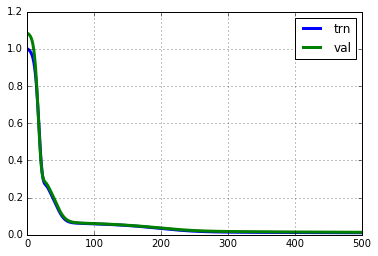

In [199]:
plt.plot(nn_trn.epoch, nn_trn.history['loss'], '-b', lw = 3, label='trn')
plt.plot(nn_trn.epoch, nn_trn.history['val_loss'], '-g', lw = 3, label='val')
plt.legend(loc='best')
plt.grid()

In [ ]:
Y = nnet.predict(data)
print(metrics.mean_squared_error(Y[itrn], data[itrn]))
print(nn_trn.history['loss'][-1])

print('validation')
print(metrics.mean_squared_error(Y[itst], data[itst]))
print(np.min(nn_trn.history['val_loss']))
print(nn_trn.history['val_loss'][-1])

In [203]:
Y = nnet.predict(data)

print('treino')
print(metrics.mean_squared_error(Y[itrn], data[itrn]))
print(np.min(nn_trn.history['loss']))
print(nn_trn.history['loss'][-1])

print('validation')
print(metrics.mean_squared_error(Y[itst], data[itst]))
print(np.min(nn_trn.history['val_loss']))
print(nn_trn.history['val_loss'][-1])

treino
0.0169675776246
0.0110705484015
0.0110705484015
validation
0.0209695817761
0.0135020529851
0.0135020529851
